In [25]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

# Options
%matplotlib inline

In [33]:
np.random.seed(9012)
# Specify domain
X = np.arange(12)[:, None]

# Specify covariance components
cov1 = pm.gp.cov.ExpQuad(1, 1.0)
cov2 = pm.gp.cov.Periodic(1, 4, 0.5)
cov3 = pm.gp.cov.WhiteNoise(1)

# Zero mean function
mean_func = pm.gp.mean.Zero()

# Draw samples from GP    
f1 = np.random.multivariate_normal(
    mean_func(X).eval(), cov1(X).eval(), 5
)#.flatten()

f2 = np.random.multivariate_normal(
    mean_func(X).eval(), cov2(X).eval(), 5
)#.flatten()

f3 = np.random.multivariate_normal(
    mean_func(X).eval(), cov3(X).eval(), 5
)#.flatten()

# Combine
f_true = f1 + f2 + f3

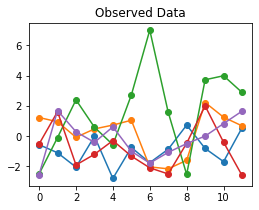

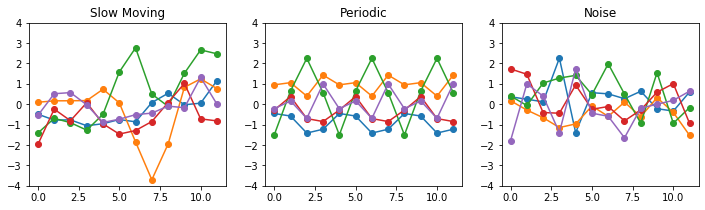

In [27]:
# Plot data
plt.figure(figsize=(4,3))
for i in range(f_true.shape[0]):
    plt.plot(X, f_true[i,:], '-o')
plt.title('Observed Data')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,3))
for i in range(f_true.shape[0]):
    ax1.plot(X, f1[i,:], '-o')
    ax2.plot(X, f2[i,:], '-o')
    ax3.plot(X, f3[i,:], '-o')
ax1.set_title('Slow Moving')
ax1.set_ylim(-4,4)
ax2.set_title('Periodic')
ax2.set_ylim(-4,4)
ax3.set_title('Noise')
ax3.set_ylim(-4,4)
plt.show()

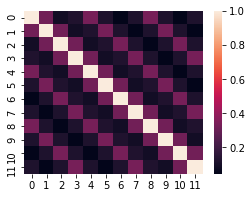

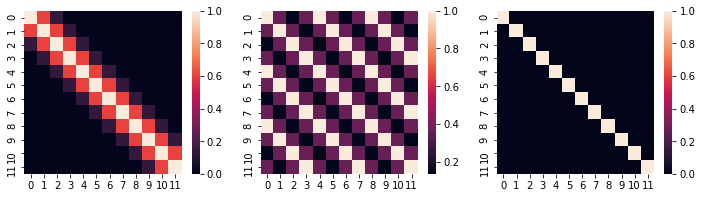

In [28]:
# Plot the covariance structure
import seaborn as sns
plt.figure(figsize=(4,3))
sns.heatmap((cov1(X).eval() + cov2(X).eval() + cov3(X).eval())/3)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,3))
sns.heatmap(cov1(X).eval(), ax=ax1);
sns.heatmap(cov2(X).eval(), ax=ax2);
sns.heatmap(cov3(X).eval(), ax=ax3);


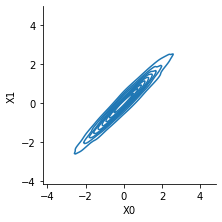

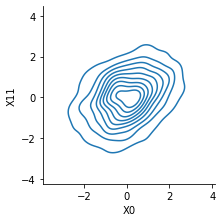

In [29]:
# Show a particular example
sig = cov1(X).eval() + cov2(X).eval() + cov3(X).eval()
sig[0,1]

samps = np.random.multivariate_normal(mean=[0,0],cov=np.array([[1,sig[0,1]],[sig[0,1], 1]]), size=1000)
samps2 = np.random.multivariate_normal(mean=[0,0],cov=np.array([[1,sig[0,11]],[sig[0,11], 1]]), size=1000)
g = sns.displot(x=samps[:,0], y=samps[:,1], kind="kde", height=3)
g.set_axis_labels('X0','X1')
g = sns.displot(x=samps2[:,0], y=samps2[:,1], kind="kde", height=3)
g.set_axis_labels('X0', 'X11');

In [71]:
f_true[0,:]

array([-0.57275372, -1.10699725, -2.05738502, -0.01916455, -2.80127357,
       -0.75827418, -1.76335386, -0.8707924 ,  0.72427505, -0.82062814,
       -1.69228048,  0.53863289])

In [75]:
# Fit model for conditional
y = f_true[0,:]
with pm.Model() as overview:
    cov1 = pm.gp.cov.ExpQuad(1, 1.0)
    cov2 = pm.gp.cov.Periodic(1, 4, 0.5)
    cov3 = pm.gp.cov.WhiteNoise(1)
    
    # Specify model structure
    gp = pm.gp.Marginal(cov_func = cov1+cov2+cov3)
    
    # Noise
    s2_n = pm.Exponential('s2_n', 1)
    
    # Learn from observed data
    gp_obs = gp.marginal_likelihood('y',
                                      noise = s2_n,
                                      X = X,
                                      y = y)
    
    mp = pm.find_MAP()

In [76]:
with overview:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s2_n]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.


In [77]:
X_new = np.linspace(0,12,100)[:, None]
with overview:
    f_pred = gp.conditional('f_pred', X_new)
    
    # Now get the predictive distribution
    pred_samples = pm.sample_posterior_predictive(trace, 
                                                  var_names = ['f_pred'],
                                                  random_seed = 1)

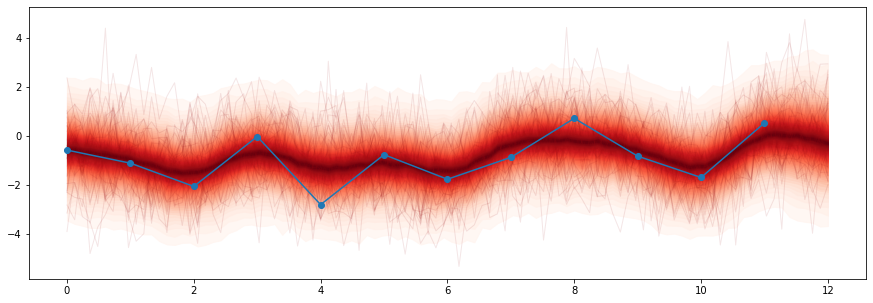

In [80]:
from pymc3.gp.util import plot_gp_dist

fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
plot_gp_dist(ax, 
             pred_samples['f_pred'], 
             X_new)
plt.plot(X,y,'o-')

### GP Priors

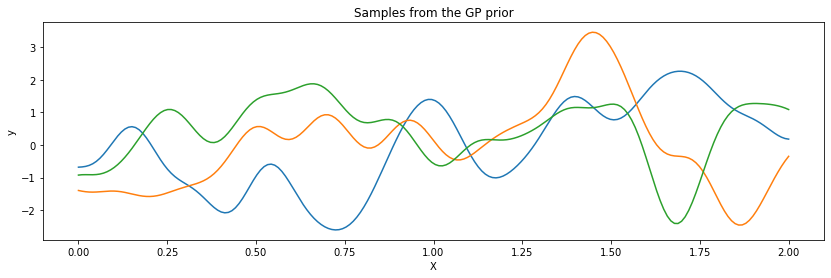

In [3]:
ls_1 = 0.1
tau_1 = 2.0
ls_2 = 0.5
tau_2 = 1.0

cov_1 = tau_1 * pm.gp.cov.ExpQuad(1, ls=ls_1)
cov_2 = tau_2 * pm.gp.cov.ExpQuad(1, ls=ls_2)

cov = cov_1 * cov_2

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

In [8]:
np.array([[0,1],[0,1]])

array([[0, 1],
       [0, 1]])

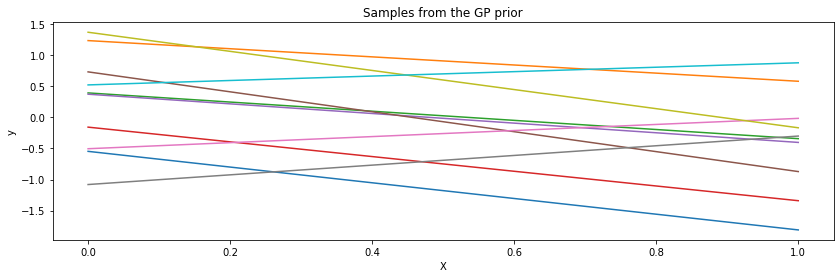

In [23]:
# ls_1 = 0.1
# tau_1 = 2.0
# ls_2 = 0.5
# tau_2 = 1.0

# cov_1 = tau_1 * pm.gp.cov.ExpQuad(1, ls=ls_1)
# cov_2 = tau_2 * pm.gp.cov.ExpQuad(1, ls=ls_2)

# cov = cov_1 * cov_2

cov = pm.gp.cov.Coregion(input_dim=1,
                         W = np.array([[0,0],[0,0]]),
                         kappa = np.array([1,1]))

# X = np.linspace(0, 2, 200)[:, None]
# X = np.array([[1,0],[0,1]])
X = np.array([0,1])[:,None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=10).T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");